# STM Dataset Simulation and Refactor

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import random
import math

## Datasets
### hour.csv

This csv file contains the information of the number of trips that ended in a specific time hour.

- season:
    - 1: Winter,
    - 2: Spring,
    - 3: Summer
    - 4: Fall
- year:
    - 0: 2011,
    - 1: 2012
- month: 1 - January to 12 - December
- hr: 0 to 23
- holiday:
    - 1: holiday
    - 0: normal work/week day
- weekday: 1 - Monday to 7 - Sunday
- workingday:
    - 0: weekend and holiday
    - 1: work day
- weathersit:
    - 1: Clear, Few Clowds, Partly Cloudy, 
    - 2: Mist and Cloudy, Mist and Broken clouds, Mist and Few clouds, Mist, 
    - 3: Light Snow, Light Rain and Thunderstorm and Scattered clouds, Light Rain and Scattered clouds, 
    - 4: Heavy Rain and Ice Pallets and Thunderstorm and Mist, Snow and Fog
- cnt: number of ended trips

It also contians a simple weather report for that hour, with:
- temperature
- temperature feeling
- humidity
- windspeed

### stations.csv

This csv file contains the information of the stations we will use to simulate the trips.

In [4]:
stations = pd.read_csv("./stationshour.csv").sort_values(by=["Station ID"])[:40]
stations.head()

,Station ID,Capacity,Latitude,Longitude,Station Name
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell"
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"
2,3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street"
3,4,23,51.530059,-0.120973,"St. Chad's Street, King's Cross"
4,5,27,51.493130,-0.156876,"Sedding Street, Sloane Square"


In [5]:
stations_ids = [x[0] for x in stations.values]

avg_point = (stations.values[0][2], stations.values[0][3])
for point in stations.values[1:]:
    avg_point = ((avg_point[0] + point[2]), (point[3] + avg_point[1]))

avg_point = (avg_point[0] / len(stations.values), avg_point[1] / len(stations.values))

# the closer to the center, the more probability of having a trip
distances = {x[0]: round(math.sqrt(math.pow(avg_point[0]-x[2],2) + math.pow(avg_point[1]-x[3],2))*1000) for x in stations.values}

In [3]:
data = pd.read_csv("./hour.csv")
data = data.dropna().drop(columns=["instant", "registered", "casual"])
data.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [21]:
def random_date(start):
    ind = random.randint(1,59)
    return datetime(start.year, start.month, start.day, start.hour, ind, start.second)

def calculate_distance(start, end):
    x = math.sin(start[2]) * math.sin(end[2]) + math.cos(start[2]) * math.cos(end[2]) * math.cos(end[3] - start[3])
    return math.acos(x) * 6371  # returns meters

trips = []

for hour in data.values:
    for trip in range(hour[-1]):
        station_start = random.choice(stations.values)
        station_end = random.choices(stations.values, weights=distances.values(), k=1)[0]
        distance = calculate_distance(station_start, station_end)
        time_travelling = (distance * random.randint(10,100)) / (20000 / 60)    # distance * randint to simulate a normal travel
        hour_date = hour[0].replace("-", "/")
        end_date_trip = random_date(datetime.strptime(f"{hour_date} {hour[4]:02d}:00:00", "%Y/%m/%d %H:%M:%S"))
        start_date_trip = end_date_trip - timedelta(minutes=int(time_travelling))
        trips.append({
            # "ID": count, 
            "StartStationID": station_start[0], 
            "EndStationID": station_end[0], 
            "Duration": int(time_travelling), 
            "StartDate": start_date_trip, 
            "EndDate": end_date_trip,
        })

trips = pd.DataFrame(trips)
trips.head()

,StartStationID,EndStationID,Duration,StartDate,EndDate
0,29,3,60,2010-12-31 23:21:00,2011-01-01 00:21:00
1,15,34,24,2010-12-31 23:46:00,2011-01-01 00:10:00
2,25,10,24,2011-01-01 00:31:00,2011-01-01 00:55:00
3,20,29,10,2011-01-01 00:25:00,2011-01-01 00:35:00
4,37,10,14,2011-01-01 00:32:00,2011-01-01 00:46:00


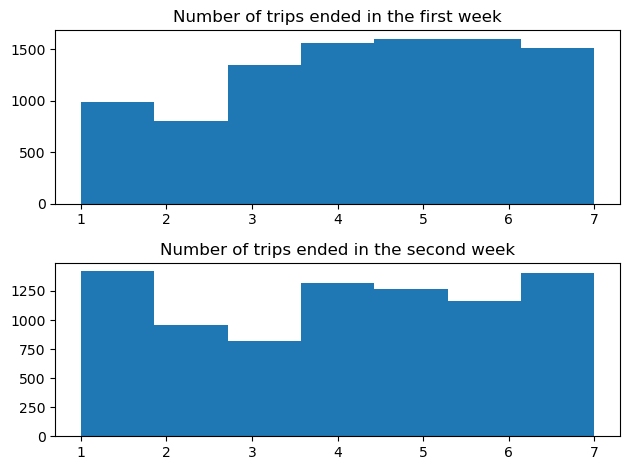

In [23]:
week = {x:0 for x in range(1,8)}
week_2 = {x:0 for x in range(1,8)}

first_day = data.values[0][0]
one_week = datetime.strptime(first_day, "%Y-%m-%d") + timedelta(days=7)
two_week = datetime.strptime(first_day, "%Y-%m-%d") + timedelta(days=14)

for trip in trips.values:
    if trip[4] <= one_week:
        week[trip[4].day] += 1
    elif trip[4] > one_week and trip[4] <= two_week:
        week_2[trip[4].day%7+1] += 1
    else:
        break
    

fig, axs = plt.subplots(2)

axs[0].hist(week.keys(), len(week), weights=list(week.values()))
axs[0].set_title("Number of trips ended in the first week")

axs[1].hist(week_2.keys(), len(week_2), weights=list(week_2.values()))
axs[1].set_title(f"Number of trips ended in the second week")

fig.tight_layout()


Text(0.5, 1.0, 'Number of trips ended in a year by weeks')

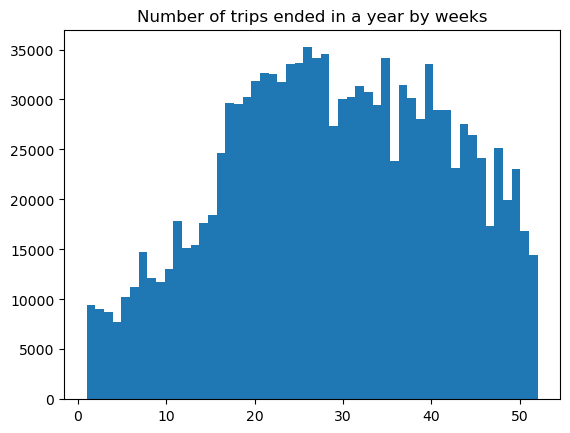

In [24]:
year = {x:0 for x in range(1,53)}

one_year = datetime.strptime(first_day, "%Y-%m-%d") + timedelta(days=365)

for trip in trips.values:
    if trip[4] > one_year:
        break

    year[trip[4].week] += 1

plt.hist(year.keys(), len(year), weights=list(year.values()))
plt.title("Number of trips ended in a year by weeks")


{1: 158, 2: 594, 3: 330, 4: 111, 5: 346, 6: 139, 7: 333, 8: 351, 9: 254, 10: 331, 11: 35, 12: 37, 13: 80, 14: 80, 15: 16, 16: 65, 17: 131, 18: 61, 19: 54, 20: 112, 21: 148, 22: 116, 23: 64, 24: 20, 25: 65, 26: 93, 27: 161, 28: 151, 29: 542, 30: 307, 31: 426, 32: 379, 33: 469, 34: 103, 36: 496, 37: 521, 38: 638, 39: 432, 40: 403, 42: 261}


Text(0.5, 1.0, 'Number of trips ended by station during the first week')

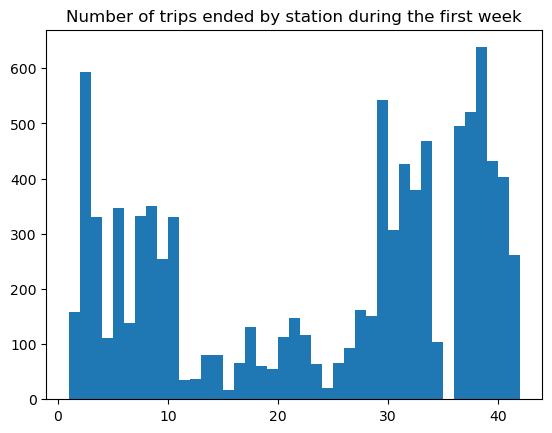

In [29]:
# num of trips by station

trips_station = {x[0]:0 for x in stations.values}

for trip in trips.values:
    if trip[4] > one_week:
        break

    trips_station[trip[1]] += 1

print(trips_station)

plt.hist(trips_station.keys(), len(trips_station)+1, weights=list(trips_station.values()))
plt.title("Number of trips ended by station during the first week")

80630


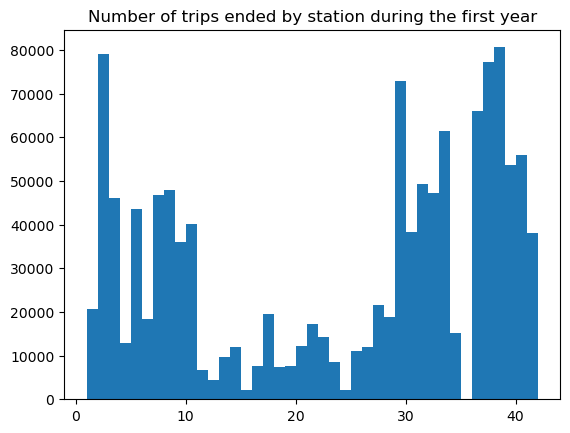

In [38]:
# num of trips by station by year

year_stations = {x[0]:0 for x in stations.values}

for trip in trips.values:
    if trip[4] > one_year:
        break

    year_stations[trip[1]] += 1

plt.hist(year_stations.keys(), len(year_stations)+1, weights=list(year_stations.values()))
plt.title("Number of trips ended by station during the first year")

In [ ]:
data.to_csv("../CSVFiles/data.csv")
stations.to_csv("../CSVFiles/stations.csv")
# for github upload
trips[:int(len(trips.values)/3)].to_csv("../CSVFiles/trips1.csv")
trips[int(len(trips.values)/3):int(len(trips.values)*2/3)].to_csv("../CSVFiles/trips2.csv")
trips[int(len(trips.values)*2/3):].to_csv("../CSVFiles/trips3.csv")

In [104]:
trips_temp = []

for hour in data.values:
    trip_by_station = {}
    hour_temp = hour.copy() 
    for trip in range(hour[-1]):
        station_end = random.choices(stations.values, weights=distances.values(), k=1)[0][0]

        if station_end in trip_by_station.keys():
            trip_by_station[station_end] += 1
        else:
            trip_by_station[station_end] = 1

    end_date_trip = random_date(datetime.strptime(hour[0], "%Y-%m-%d"))

    for station, count in trip_by_station.items():
        trips_temp.append({
            "DateEnd": end_date_trip,
            "StationEnd": station,
            "Count": count,
            "Season": hour[1],
            "Year": hour[2],
            "Month": hour[3],
            "Hour": hour[4],
            "Holiday": hour[5],
            "Weekday": hour[6],
            "Workingday": hour[7],
            "WeatherSituation": hour[8],
            "Temp": hour[9],
            "ATemp": hour[10],
            "Humidity": hour[11],
            "Windspeed": hour[12],
        })

trips_temp = pd.DataFrame(trips_temp)
trips_temp.head()

,DateEnd,StationEnd,Count,Season,Year,Month,Hour,Holiday,Weekday,Workingday,WeatherSituation,Temp,ATemp,Humidity,Windspeed
0,2011-01-01 00:23:00,27,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,2011-01-01 00:23:00,42,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
2,2011-01-01 00:23:00,29,2,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
3,2011-01-01 00:23:00,2,2,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
4,2011-01-01 00:23:00,38,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0


In [150]:
trips_2 = trips_temp.loc[trips_temp["StationEnd"] == 39]
# trips_2 = trips_temp.loc[trips_temp["Season"] == 1]
trips_2 = trips_2.loc[trips_temp["DateEnd"] <= datetime.strptime(first_day, "%Y-%m-%d") + timedelta(days=245)]

# trips_2.loc[trips_2['Season'] == 1, 'Season'] = "Winter"
# trips_2.loc[trips_2['Season'] == 2, 'Season'] = "Spring"
# trips_2.loc[trips_2['Season'] == 3, 'Season'] = "Summer"
# trips_2.loc[trips_2['Season'] == 4, 'Season'] = "Fall"

trips_2 = pd.get_dummies(data=trips_2, columns=["Holiday"], dtype=int)
trips_2 = pd.get_dummies(data=trips_2, columns=["Weekday"], dtype=int)
# trips_2 = pd.get_dummies(data=trips_2, columns=["WeatherSituation"], dtype=bool)
# trips_2 = pd.get_dummies(data=trips_2, columns=["Season"], dtype=bool, prefix="", prefix_sep="")
# trips_2 = pd.get_dummies(data=trips_2, columns=["Year"], dtype=bool)
# trips_2 = pd.get_dummies(data=trips_2, columns=["Month"], dtype=bool)
# trips_2 = pd.get_dummies(data=trips_2, columns=["Hour"], dtype=int)
trips_2 = pd.get_dummies(data=trips_2, columns=["Workingday"], dtype=int)

cols = trips_2.columns.tolist()
cols = cols[3:] + cols[0:3]

trips_2 = trips_2[cols]

/tmp/ipykernel_7521/1552068443.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  con_corr = trips_2.corr()


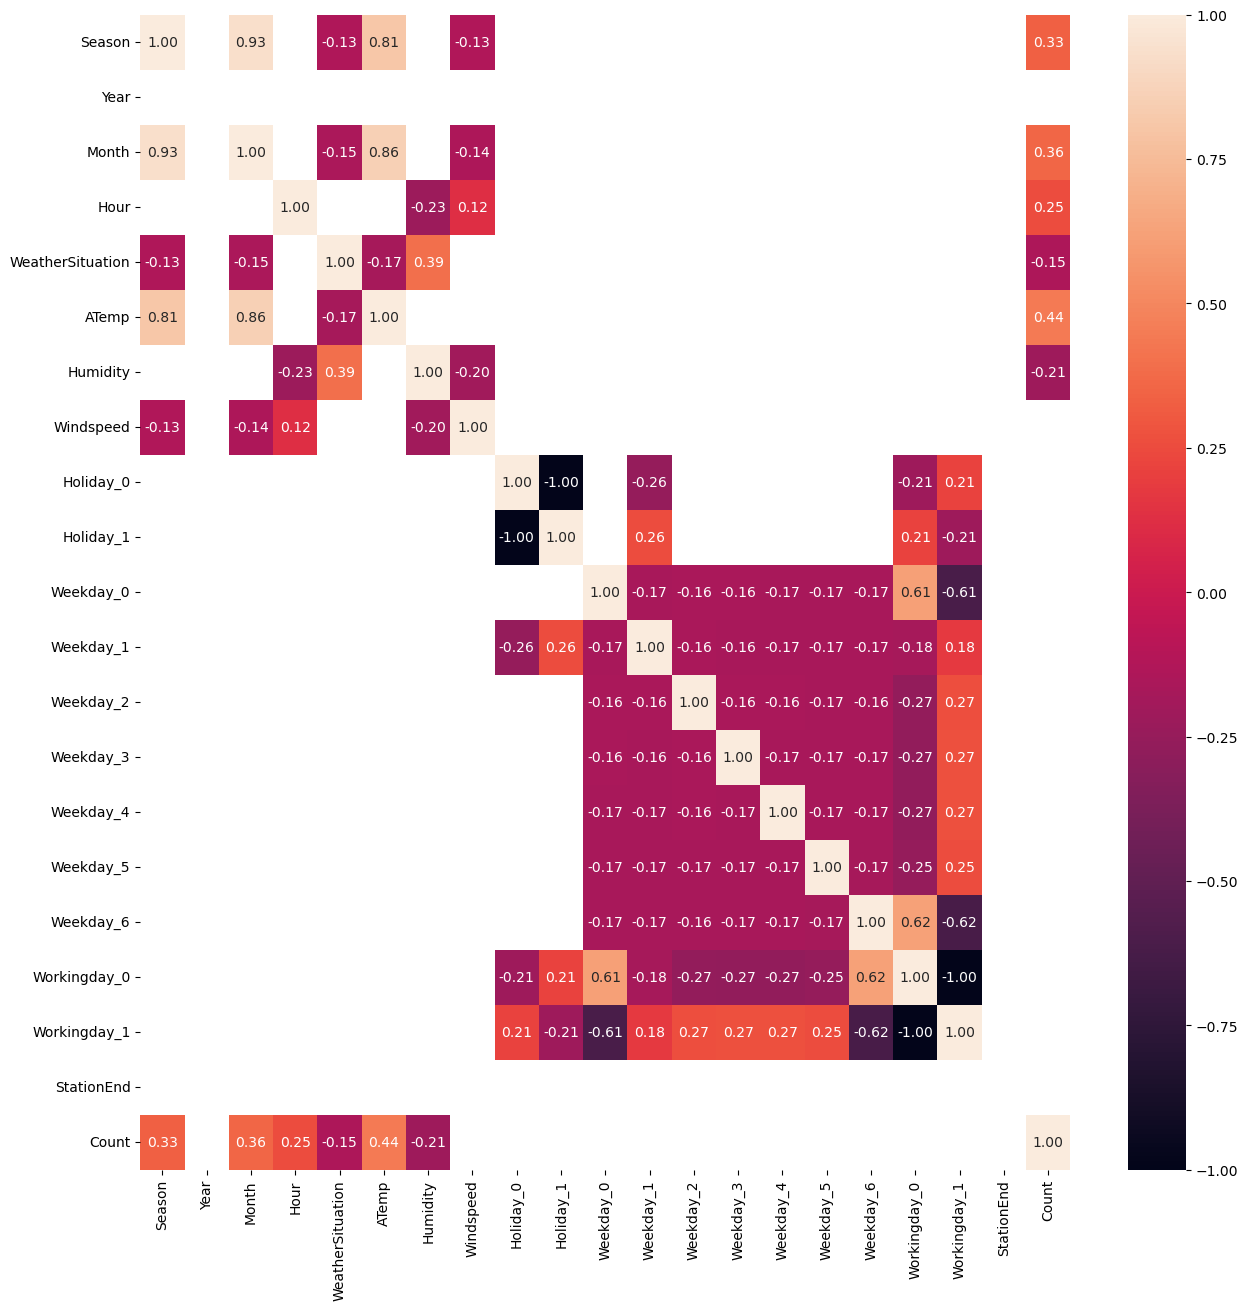

In [151]:
import seaborn as sns

trips_2 = trips_2.drop(columns=["Temp", "StationEnd"])
# trips_2 = trips_2.drop(columns=["Holiday", "Weekday", "Temp", "Workingday", "StationEnd", "Windspeed"])

con_corr = trips_2.corr()
mask_con_corr = con_corr[(con_corr >= 0.1) | (con_corr <= -0.1)]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
fig = sns.heatmap(mask_con_corr, vmin=-1, vmax=1, annot=True, fmt='0.2f')

In [27]:
trips_temp.to_csv("../CSVFiles/datatrips.csv")

# for github upload
# trips_temp[:int(len(trips_temp.values)/3)].to_csv("../CSVFiles/datatrips1.csv")
# trips_temp[int(len(trips_temp.values)/3):int(len(trips_temp.values)*2/3)].to_csv("../CSVFiles/datatrips2.csv")
# trips_temp[int(len(trips_temp.values)*2/3):].to_csv("../CSVFiles/datatrips3.csv")